In [1]:
# Allow GPU memory growth
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [4]:
import os
import cv2
import csv
import time
import requests
import numpy as np
import pandas as pd
np.random.seed(2345) 
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import vgg16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.python.client import device_lib
from scipy import misc
from skimage import io
import skimage.transform as st
import scikitplot as skplt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
%pylab inline
import h5py
import json
from flask import Flask, request, render_template

Populating the interactive namespace from numpy and matplotlib


### Data Preparation

In [6]:
# Read csv file
df = pd.read_csv('trainLabels_bird.csv')
df.head()

,filename,label
0,_JWO0007_cr,Stork-billed_Kingfisher
1,_JWO0008_cr,Banded_Woodpecker
2,_JWO0019_cr,Banded_Woodpecker
3,_JWO0044_cr,Common_Redshank
4,_JWO0046_cr,Common_Redshank


In [7]:
# Check for duplicate rows
dups = df.duplicated()
print('Number of duplicate rows = %d' % (dups.sum())) 

Number of duplicate rows = 0


In [8]:
df.groupby('label').count()

,filename
label,
Amur_Asian_Paradise_Flycatcher,4
Asian_Glossy_Starling,2
Asian_Koel,6
Banded_Woodpecker,19
Black-crowned_Night_Heron,16
...,...
Yellow_Bittern,10
Yellow_Oriole,2
Zanzibar_Red_Bishop,13


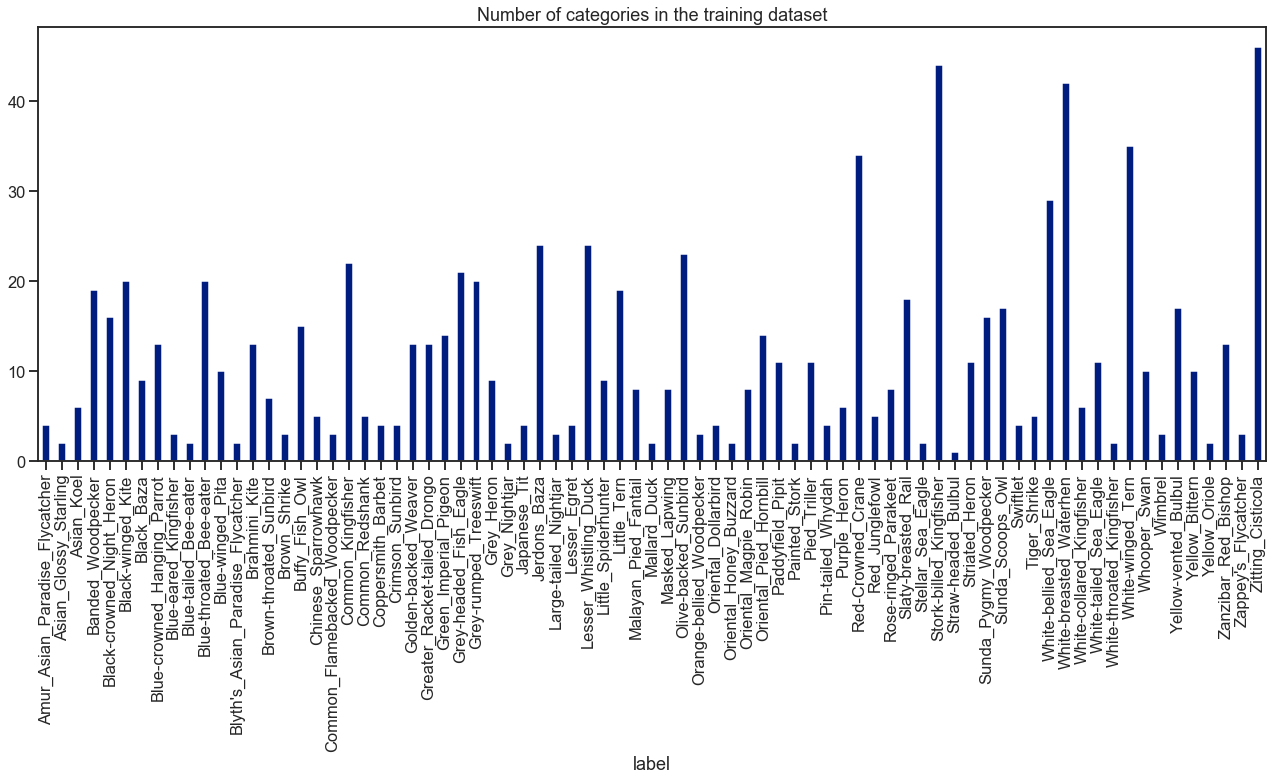

In [9]:
sns.set_context('talk')
sns.set_palette('dark')
sns.set_style('ticks')

plt.figure(figsize=(22, 8))
df.groupby(['label']).count()['filename'].plot(kind='bar', title='Number of categories in the training dataset');

### Data Augmentation

In [ ]:
PATH = os.getcwd()
data_path = PATH + '/train_birds_dataset'
data_dir_list = os.listdir(data_path)

In [ ]:
# Create new directory to store processed images
os.makedirs('train_birds_sorted', exist_ok=True) 

SOURCE_ROOT = 'train_birds_dataset'
DEST_ROOT = 'train_birds_sorted'

with open('trainLabels_bird.csv') as infile:
    next(infile)  # Skip the header row
    reader = csv.reader(infile)
    seen = set()
    for birdID, breed in reader:
        if breed not in seen:
            os.mkdir(os.path.join(DEST_ROOT, breed))
            seen.add(breed)

        src = os.path.join(SOURCE_ROOT, birdID + '.jpg')
        dest = os.path.join(DEST_ROOT, breed, birdID + '.jpg')

        try:
            os.rename(src, dest)
        except WindowsError as e:
            print(e)

### Load Dataset with Augmentation

In [10]:
path = os.getcwd() + '/train_birds_sorted'

Total number of categories: 77
Total number of images in dataset: 7700


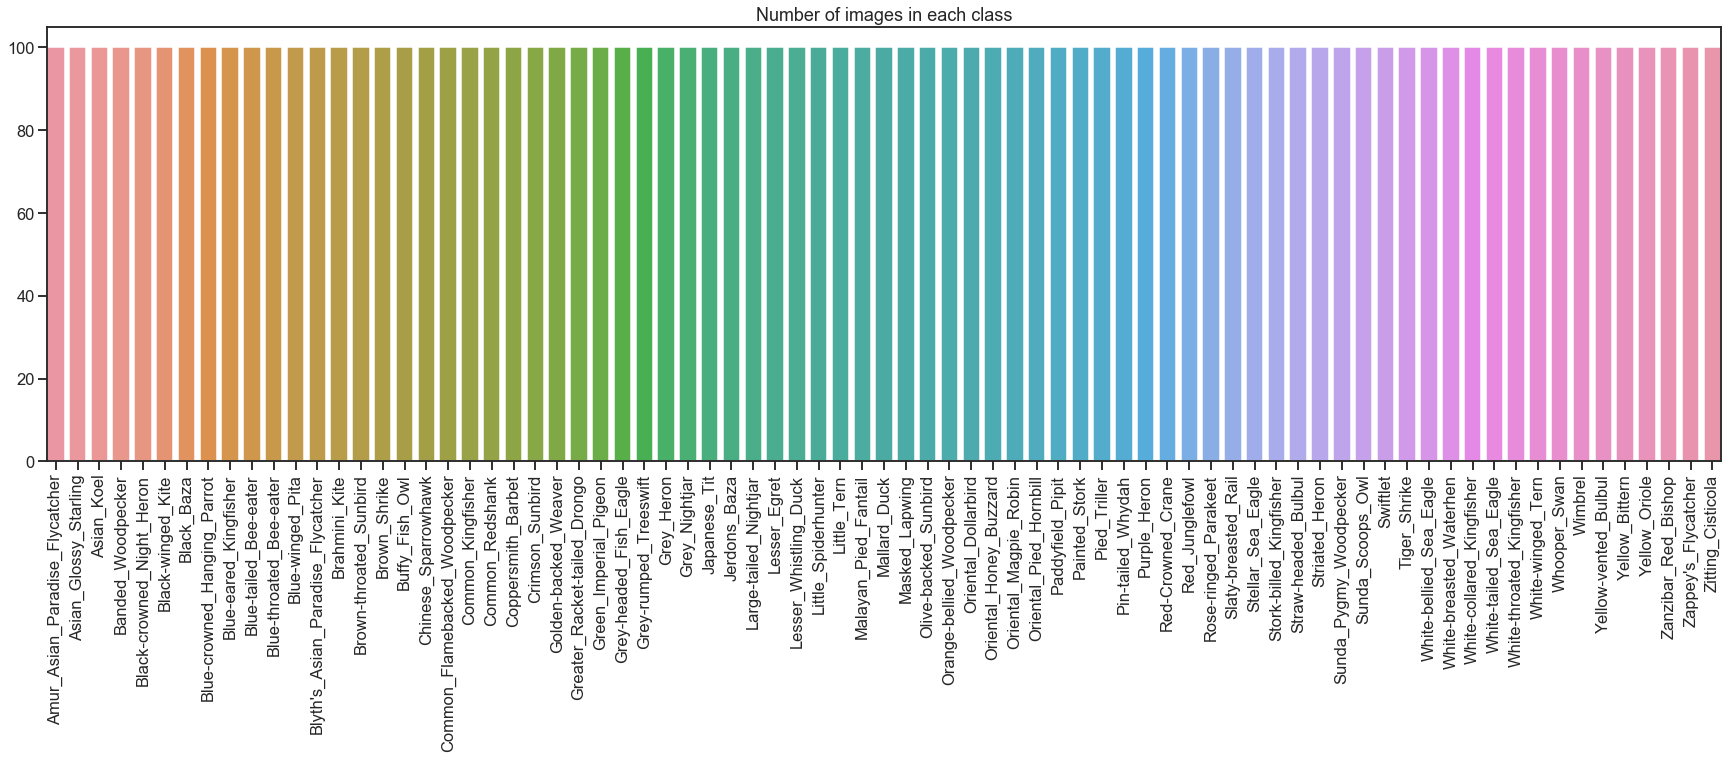

In [11]:
classes = os.listdir((path))
print(f'Total number of categories: {len(classes)}')

# Create a dictionary which contains class and number of images in that class
counts = {}
for i in classes:
    counts[i] = len(os.listdir(os.path.join(path, i)))
    
print(f'Total number of images in dataset: {sum(list(counts.values()))}')

# Plot the number of images in each class
sns.set_context('talk')
sns.set_palette(sns.color_palette('muted'))
sns.set_style('ticks')

plt.figure(figsize=(30, 8))
sns.barplot(x=list(counts.keys()), y=list(counts.values())).set_title('Number of images in each class')
plt.xticks(rotation = 90)
plt.margins(x=0)
plt.show()

In [12]:
# Create dataset and sort the items in the dictionary
dataset = sorted(counts.items(), key=lambda x:x[1],reverse = True)
print(dataset)

# Extract labels
dataset = [i[0] for i in dataset]
print(dataset)

[('Amur_Asian_Paradise_Flycatcher', 100), ('Asian_Glossy_Starling', 100), ('Asian_Koel', 100), ('Banded_Woodpecker', 100), ('Black-crowned_Night_Heron', 100), ('Black-winged_Kite', 100), ('Black_Baza', 100), ('Blue-crowned_Hanging_Parrot', 100), ('Blue-eared_Kingfisher', 100), ('Blue-tailed_Bee-eater', 100), ('Blue-throated_Bee-eater', 100), ('Blue-winged_Pita', 100), ("Blyth's_Asian_Paradise_Flycatcher", 100), ('Brahmini_Kite', 100), ('Brown-throated_Sunbird', 100), ('Brown_Shrike', 100), ('Buffy_Fish_Owl', 100), ('Chinese_Sparrowhawk', 100), ('Common_Flamebacked_Woodpecker', 100), ('Common_Kingfisher', 100), ('Common_Redshank', 100), ('Coppersmith_Barbet', 100), ('Crimson_Sunbird', 100), ('Golden-backed_Weaver', 100), ('Greater_Racket-tailed_Drongo', 100), ('Green_Imperial_Pigeon', 100), ('Grey-headed_Fish_Eagle', 100), ('Grey-rumped_Treeswift', 100), ('Grey_Heron', 100), ('Grey_Nightjar', 100), ('Japanese_Tit', 100), ('Jerdons_Baza', 100), ('Large-tailed_Nightjar', 100), ('Lesser_Eg

In [13]:
X = [] # Empty list for images
Y = [] # Empty list for labels

IMAGE_DIMS = (128, 128, 3) # Set image dimensions

# Loop through all classes
for c in classes:
    if c in dataset:
        dir_path = os.path.join(path, c)
        label = dataset.index(c) # the label is an index of class in data
        
        # Read, resize, add images and labels to lists
        for i in os.listdir(dir_path):
            image = cv2.imread(os.path.join(dir_path, i))
            
            try:
                resized = cv2.resize(image,(IMAGE_DIMS[0],IMAGE_DIMS[1]))
                X.append(resized)
                Y.append(label)

            except:
                print(os.path.join(dir_path, i), '[ERROR] can\'t read the file.')
                continue       

# Convert list with images to numpy array and reshape it 
X = np.array(X).reshape(-1, IMAGE_DIMS[0], IMAGE_DIMS[1],IMAGE_DIMS[2])

# Scale data in array
X = X / 255.0
print(X.shape)

# Convert labels to categorical format
y = to_categorical(Y, num_classes = len(dataset))

(7700, 128, 128, 3)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y, shuffle=True, random_state=1)

### Creation of CNN using Transfer Learning 

In [18]:
# Import VGG16 from keras with pre-trained weights that is trained on imagenet
# Include_top=False to exclude the top classification layer 
# weights='imagenet' to use the weights from pre-training on Imagenet

base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=IMAGE_DIMS)

for layer in base_model.layers:
     layer.trainable = False

In [19]:
# Build the classification layers on top of the base VGG16 base layers for the dataset
model = tf.keras.Sequential(base_model.layers)

model.add(Flatten())
model.add(Dense(512, activation='relu'))   
model.add(tf.keras.layers.Dropout(0.5))
model.add(Dense(256, activation='relu'))  
model.add(tf.keras.layers.Dropout(0.5))
model.add(Dense(len(dataset), activation = 'softmax'))

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=keras.losses.categorical_crossentropy, 
              metrics=['accuracy'])

model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 32, 32, 256)       2

### Model Training

In [3]:
# Set as 1 to train model, 0 to skip model training and load pre-trained model
train_models_flag = 1

In [20]:
epochs = 10
batch_size = 128

In [21]:
if train_models_flag == 1: 
    # Train the model
    start = time.time()
    
    model_info = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                           batch_size=batch_size, epochs=epochs,
                           verbose=1)
    end = time.time()
    model.save('saved_models/model.h5')

else:
    # load Model
    saved_model = 'saved_models/model.h5'
    model = load_model(saved_model)

Epoch 1/10
49/49 [==============================] - 60s 1s/step - loss: 3.6689 - accuracy: 0.1594 - val_loss: 1.5394 - val_accuracy: 0.8753
Epoch 2/10
49/49 [==============================] - 48s 977ms/step - loss: 1.5660 - accuracy: 0.5976 - val_loss: 0.3406 - val_accuracy: 0.9506
Epoch 3/10
49/49 [==============================] - 48s 979ms/step - loss: 0.7866 - accuracy: 0.7968 - val_loss: 0.2005 - val_accuracy: 0.9591
Epoch 4/10
49/49 [==============================] - 48s 971ms/step - loss: 0.5330 - accuracy: 0.8627 - val_loss: 0.1625 - val_accuracy: 0.9643
Epoch 5/10
49/49 [==============================] - 48s 980ms/step - loss: 0.3736 - accuracy: 0.8981 - val_loss: 0.1389 - val_accuracy: 0.9682
Epoch 6/10
49/49 [==============================] - 48s 976ms/step - loss: 0.2868 - accuracy: 0.9247 - val_loss: 0.1253 - val_accuracy: 0.9760
Epoch 7/10
49/49 [==============================] - 47s 967ms/step - loss: 0.2612 - accuracy: 0.9291 - val_loss: 0.1078 - val_accuracy: 0.9760
Ep

## Learning Curves

In [22]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    # Summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best', shadow=True)
    
    # Summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best', shadow=True)
    plt.show()

In [23]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

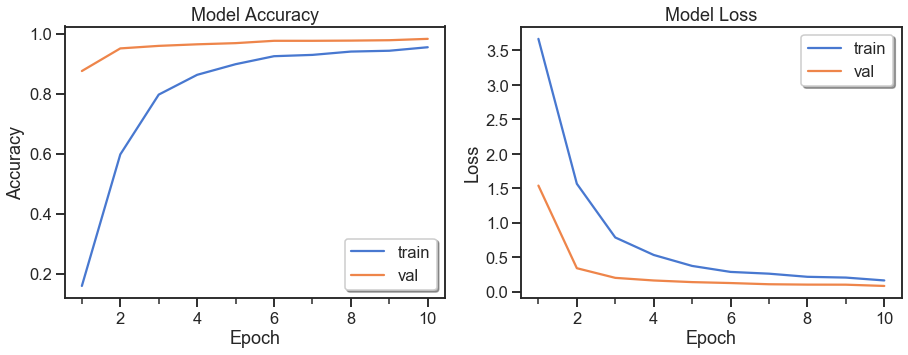

Model took 533.3742039203644 seconds to train.
Accuracy on test data is: 98.25%.


In [24]:
if train_models_flag == 1:
    # Plot model history
    plot_model_history(model_info)
    print ("Model took {} seconds to train.".format(end - start))
    
# Compute test accuracy
print ("Accuracy on test data is: {:.2f}%.".format(accuracy(X_test, y_test, model)))

## Model Deployment using Flask

In [32]:
def classify(image, model):
    class_names = ['Amur_Asian_Paradise_Flycatcher','Asian_Glossy_Starling','Asian_Koel','Banded_Woodpecker','Black_Baza',
                  'Black-crowned_Night_Heron','Black-winged_Kite','Blue-crowned_Hanging_Parrot','Blue-eared_Kingfisher',
                  'Blue-tailed_Bee-eater','Blue-throated_Bee-eater','Blue-winged_Pita','Blyth\'s_Asian_Paradise_Flycatcher',
                  'Brahmini_Kite','Brown_Shrike','Brown-throated_Sunbird','Buffy_Fish_Owl','Chinese_Sparrowhawk',
                  'Common_Flamebacked_Woodpecker','Common_Kingfisher','Common_Redshank','Coppersmith_Barbet',
                  'Crimson_Sunbird','Golden-backed_Weaver','Greater_Racket-tailed_Drongo','Green_Imperial_Pigeon',
                  'Grey_Heron','Grey_Nightjar','Grey-headed_Fish_Eagle','Grey-rumped_Treeswift','Japanese_Tit',
                  'Jerdons_Baza','Large-tailed_Nightjar','Lesser_Egret','Lesser_Whistling_Duck','Little_Spiderhunter',
                  'Little_Tern','Malayan_Pied_Fantail','Mallard_Duck','Masked_Lapwing','Olive-backed_Sunbird',
                  'Orange-bellied_Woodpecker','Oriental_Dollarbird','Oriental_Honey_Buzzard','Oriental_Magpie_Robin',
                  'Oriental_Pied_Hornbill','Paddyfield_Pipit','Painted_Stork','Pied_Triller','Pin-tailed_Whydah',
                  'Purple_Heron','Red_Junglefowl','Red-Crowned_Crane','Rose-ringed_Parakeet','Slaty-breasted_Rail',
                  'Stellar_Sea_Eagle','Stork-billed_Kingfisher','Straw-headed_Bulbul','Striated_Heron',
                  'Sunda_Pygmy_Woodpecker','Sunda_Scoops_Owl','Swiftlet','Tiger_Shrike','White-bellied_Sea_Eagle',
                  'White-breasted_Waterhen','White-collared_Kingfisher','White-tailed_Sea_Eagle','White-throated_Kingfisher',
                  'White-winged_Tern','Whooper_Swan','Wimbrel','Yellow_Bittern','Yellow_Oriole','Yellow-vented_Bulbul',
                  'Zanzibar_Red_Bishop','Zappey\'s_Flycatcher','Zitting_Cisticola']
    
    preds = model.predict(image)
    classification = np.argmax(preds)
    final = pd.DataFrame({'name' : np.array(class_names),'probability' :preds[0]})
    return final.sort_values(by = 'probability',ascending=False).head(10),class_names[classification]

## Define the Flask Application

In [37]:
app = Flask(__name__) 

@app.route('/')
def entry_page():
    #Jinja template of the webpage
    return render_template('index.html')

@app.route('/predict_object/', methods=['GET', 'POST'])
def render_message():
    #Loading CNN model
    saved_model = 'saved_models/model.h5'
    model = load_model(saved_model)
    
    try:
        # Get image URL as input
        image_url = request.form['image_url']
        image = io.imread(image_url)
        
        # Apply same preprocessing used while training CNN model
        test_image = st.resize(image, (IMAGE_DIMS[0], IMAGE_DIMS[1]))
        x = np.expand_dims(test_image, axis=0)
       
        # Call classify function to predict the image class using the loaded CNN model
        final, pred_class = classify(x, model)
        print(pred_class)
        print(final)
        
        # Store model prediction results to pass to the web page
        message = "Model prediction: {}".format(pred_class)
        print('Python module executed successfully')
        
    except Exception as e:
        # Store error to pass to the web page
        message = "Error encountered. Try another image. ErrorClass: {}, Argument: {} and Traceback details are: {}".format(e.__class__,e.args,e.__doc__)
        final = pd.DataFrame({'A': ['Error'], 'B': [0]})
        
    # Return the model results to the web page
    return render_template('index.html',
                            message=message,
                            data=final.round(decimals=2),
                            image_url=image_url)

## Run the Flask Application

In [38]:
# Debug is disabled for running in a jupyter notebook
app.run(debug = False)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [29/Aug/2020 12:35:12] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [29/Aug/2020 12:35:26] "POST /predict_object/ HTTP/1.1" 200 -


White-throated_Kingfisher
                              name  probability
67       White-throated_Kingfisher     0.944640
14                    Brown_Shrike     0.031102
0   Amur_Asian_Paradise_Flycatcher     0.007745
56         Stork-billed_Kingfisher     0.005500
27                   Grey_Nightjar     0.001954
44           Oriental_Magpie_Robin     0.001113
9            Blue-tailed_Bee-eater     0.000946
15          Brown-throated_Sunbird     0.000782
10         Blue-throated_Bee-eater     0.000652
24    Greater_Racket-tailed_Drongo     0.000650
Python module executed successfully
